In [1]:
#Clustering and RANSAC for WDD2017 paper
#Fernando Wario
#June 2017

%matplotlib notebook

import csv
import cv2
import datetime
import glob
import json
import math
import numpy as np
import os
import pandas
import sys
import scipy.cluster
import matplotlib.mlab as mlab
import matplotlib.cm as cm
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from joblib import Parallel, delayed
from sklearn import preprocessing
from sklearn.linear_model import TheilSenRegressor
from skimage.transform import radon, rescale
from scipy.stats import multivariate_normal
from scipy import stats
from io import BytesIO

sys.path.append('../functions/')
sys.path.append('../utils/')

from VidPlayer import VidPlayer
from wdd_clustering_functions import data_format, generate_clusters, clean_clusters

#Radian
radi = 180/np.pi

In [2]:
#Decoder data is loaded
A={}
C={}
CClusters={}
#DECODER DATA
#Path to the Decoder data
inputFile = '../Data/GTRuns_decoder.csv'
#inputFile = '../Data/Filtering/20160816_11_filtered.csv'
#inputFile = '../Data/Filtering/20160816_total_filtered.csv'
#Extract data for camera 1, remember to set third parameter to 1 if ploting on a map
A = data_format(inputFile, '1', 1)
print('Done loading data to A, {0} WRuns found'.format(len(A)))
#Generates clusters
max_d = 15
C = generate_clusters(A, max_d)
print('Done with C {0} clusters found'.format(len(C)))
#input arguments for clean_clusters()
#number of angles to generate model
n = 3
#threshold to be considered as inlier
t = np.pi/5
#clean clusters after removing outlayers and short dances
CClusters = clean_clusters(A, C, n, t)
print('Done with CClusters {0} clusters remained'.format(len(CClusters)))

Done loading data to A, 187 WRuns found
Done with C 49 clusters found
Done with CClusters 22 clusters remained


In [3]:
#DEBUGGING
#Generate the linkage matrix
B = np.array([[A[key][2], A[key][3], A[key][4]/4] for key in A])
Z = scipy.cluster.hierarchy.linkage(B, 'ward')
print('Done with Z')
print('Shape of Z: ' + str(Z.shape))

Done with Z
Shape of Z: (186, 4)


<IPython.core.display.Javascript object>


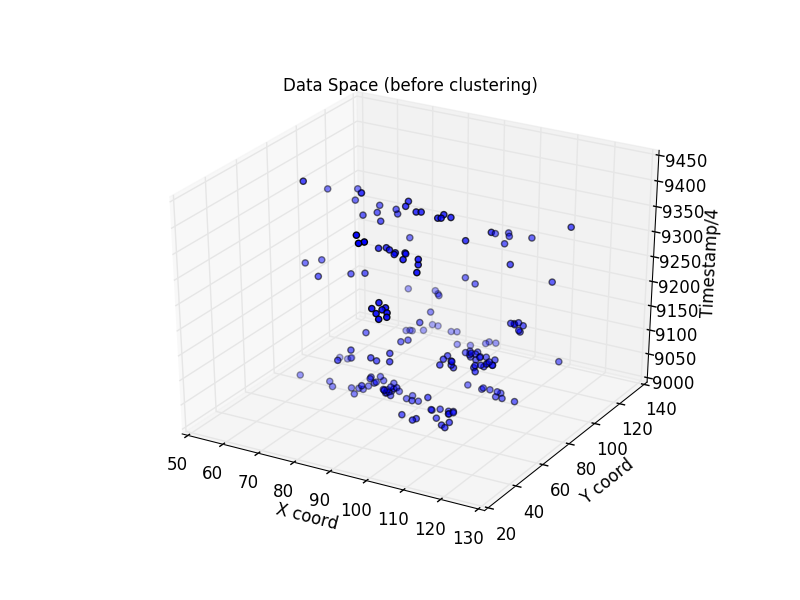

In [4]:
#DEBUGGING
#3D scatterplot

fig = plt.figure(dpi=100)

ax = fig.add_subplot(111, projection='3d')
ax.scatter(B[:,0], B[:,1], B[:,2], c='b', marker = 'o')

ax.set_title('Data Space (before clustering)', fontsize=12)
ax.set_xlabel('X coord', fontsize=12)
ax.set_ylabel('Y coord', fontsize=12)
ax.set_zlabel('Timestamp/4', fontsize=12)

plt.show()
# save figure
# Save the image in memory in PNG format
#fig.savefig('png1.png', format='png')

<IPython.core.display.Javascript object>


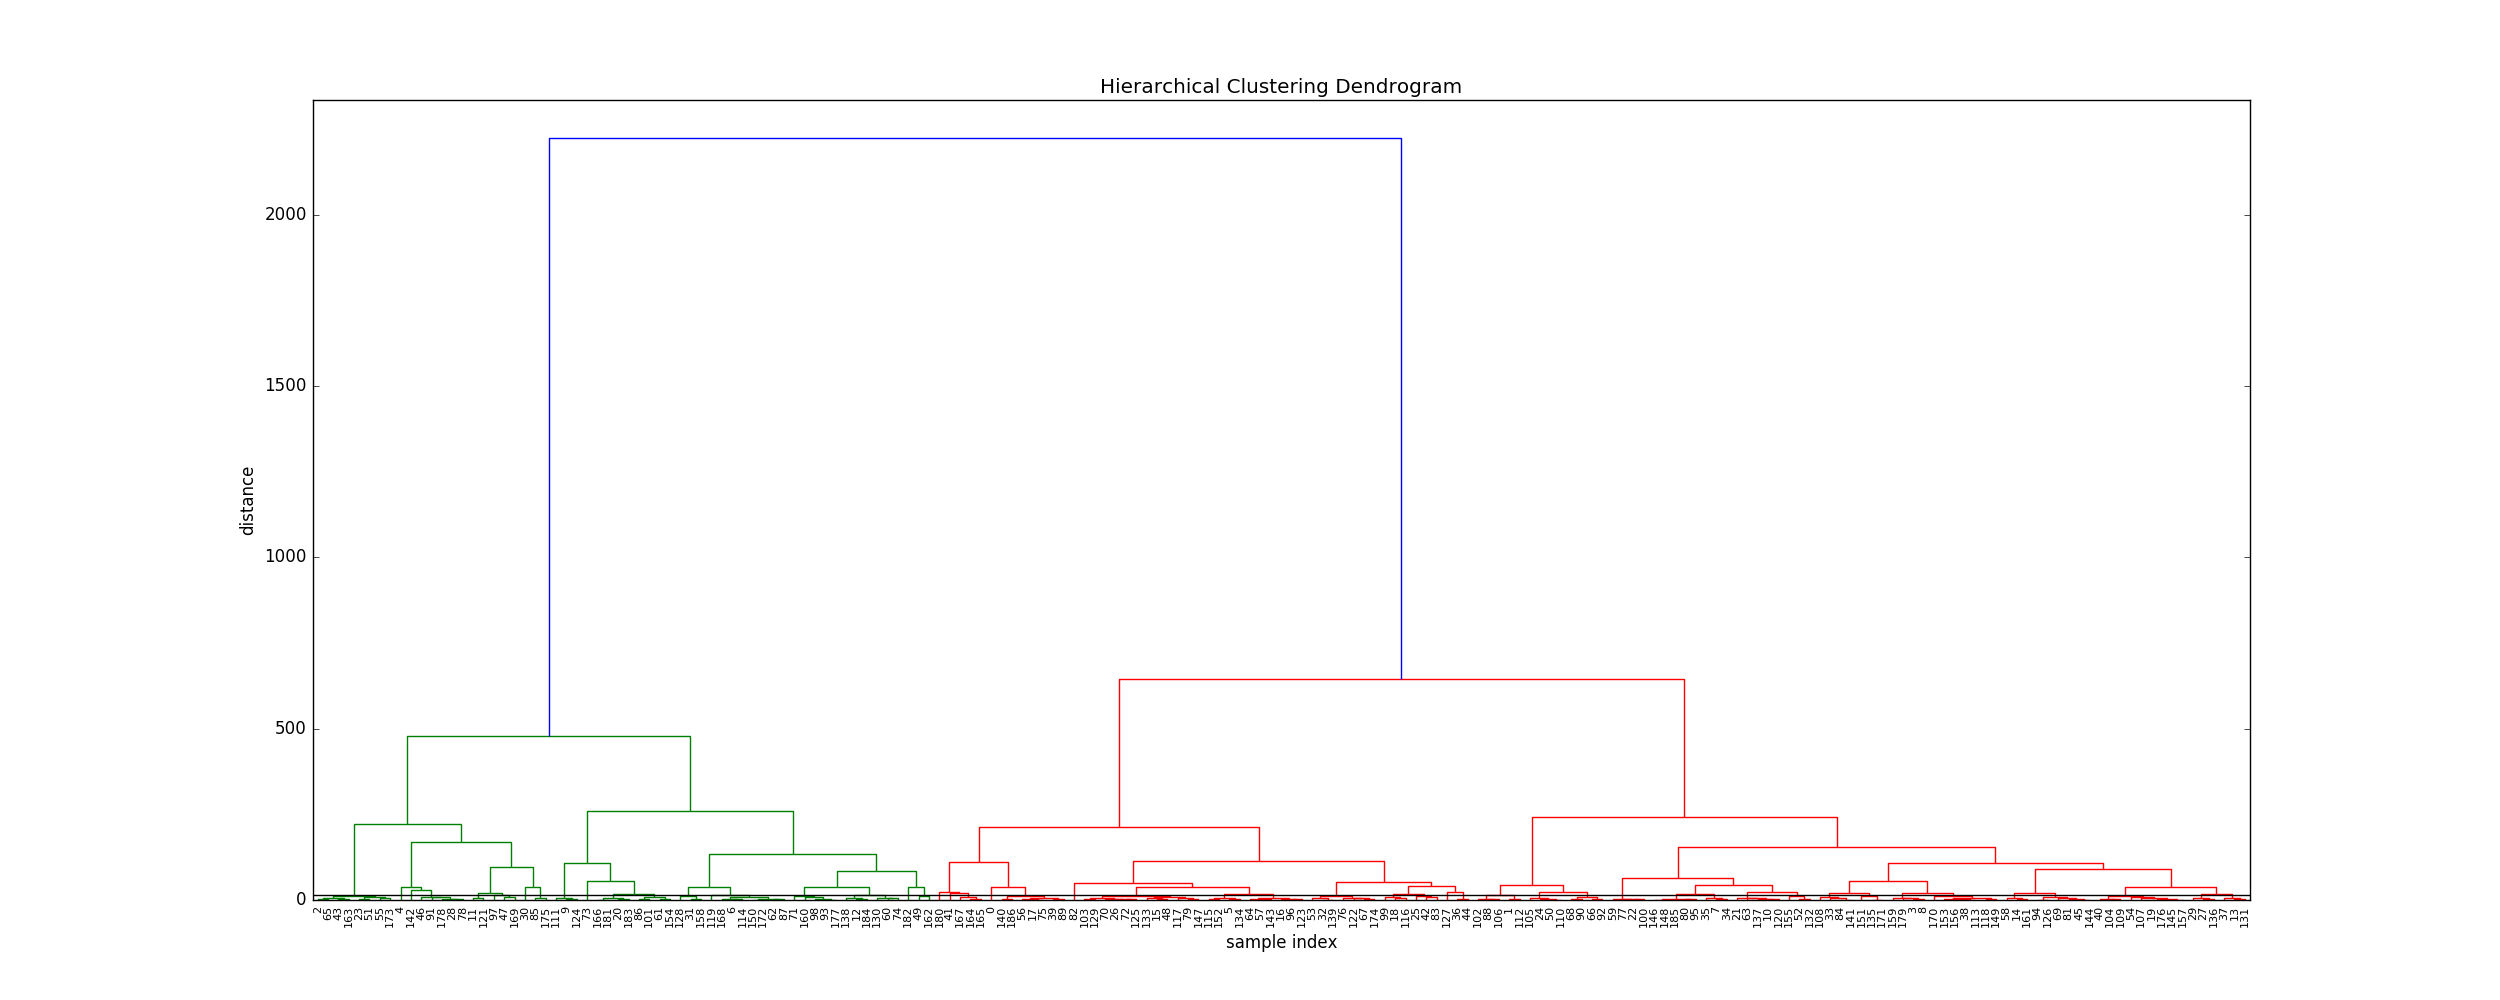

In [4]:
#DEBUGGING
#Plotting dendrogram
fig2 = plt.figure(figsize=(25, 10), dpi=100)
#fig2 = plt.figure(dpi=600)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
scipy.cluster.hierarchy.dendrogram(
    Z,
    #truncate_mode='level',  # show only the last p merged clusters
    #p=4,  # show only the last p merged clusters
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels    
)
plt.axhline(y=max_d, c='k')
plt.show()
# save figure
# Save the image in memory in PNG format
#fig2.savefig('dendogram2.png', format='png')

Number of clusters: 35


<IPython.core.display.Javascript object>


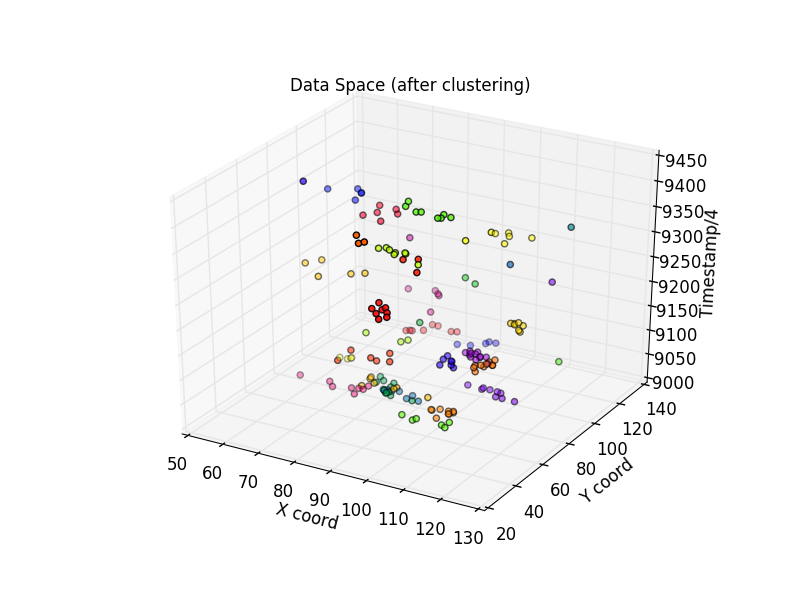

In [29]:
#DEBUGGING
#Clustering with a maximum euclidian distance in space of 25 units
max_d = 25
clusters = scipy.cluster.hierarchy.fcluster(Z, max_d, criterion='distance')
print('Number of clusters: '+ str(max(clusters)))
fig4 = plt.figure(dpi=100)
bx = fig4.add_subplot(111, projection='3d')
# plot points with cluster dependent colors
bx.scatter(B[:,0], B[:,1], B[:,2], c=clusters, cmap='prism')
bx.set_title('Data Space (after clustering)', fontsize=12)
bx.set_xlabel('X coord', fontsize=12)
bx.set_ylabel('Y coord', fontsize=12)
bx.set_zlabel('Timestamp/4', fontsize=12)
plt.show()
# save figure
# Save the image in memory in PNG format
#fig4.savefig('png2.png', format='png')

In [7]:
#DEBUGGING
################# Displays WR's as videos ##############
#To skip to the next dance press "Y"
#To close the window press "Esc"
#Path to the Waggle runs
path = '../Data/GTRuns/'

#control variables initialized
cluster = 0
next = 0
first_frame = True

while (cluster < len(C) and next != -1):
    cluster_key = str(cluster + 1)
    counter = 0
    while (counter < len(C[cluster_key]) and next != -1):    
        key = C[cluster_key][counter][0]
        pathWR = (path + key + '/')
        #vp object is initialized
        vp = VidPlayer()
        #waggle run images
        vp.set_vid_path(pathWR + 'image_%03d.png')
        capture = vp.get_vid_capture()
        #The video is played in a loop
        while(vp.get_vid_running()):
            ret, image = capture.read()
            if (ret == True):
                #image is resized
                image = cv2.resize(image, None, fx = 8, fy = 8, interpolation = cv2.INTER_CUBIC)
                #Info is displayed in the video window
                #Path is displayed
                cv2.putText(image,key,(10,20), cv2.FONT_HERSHEY_SIMPLEX, .5,(255,255,255),1,cv2.LINE_AA)
                #Counter is displayed
                cv2.putText(image,'WR %2d' %int(counter + 1),(350,16), cv2.FONT_HERSHEY_SIMPLEX, .25,(255,255,255),1,cv2.LINE_AA)
                cv2.putText(image,'from %2d' %int(len(C[cluster_key])),(345,26), cv2.FONT_HERSHEY_SIMPLEX, .25,(255,255,255),1,cv2.LINE_AA)
                #Cluster number is displayed
                cv2.putText(image,'Cluster ' + cluster_key,(300,16), cv2.FONT_HERSHEY_SIMPLEX, .25,(255,255,255),1,cv2.LINE_AA)            
                #Angles are displayed            
                cv2.putText(image,'X0         = %5.4f ' %A[key][2],(10,338), cv2.FONT_HERSHEY_SIMPLEX, .5,(255,255,255),1,cv2.LINE_AA)
                cv2.putText(image,'Y0         = %5.4f ' %A[key][3],(10,356), cv2.FONT_HERSHEY_SIMPLEX, .5,(255,255,255),1,cv2.LINE_AA)
                cv2.putText(image,'Timestamp  = %5d   ' %A[key][4],(10,374), cv2.FONT_HERSHEY_SIMPLEX, .5,(255,255,255),1,cv2.LINE_AA)
                cv2.putText(image,'Dec_angle  = %5.4f' %float(A[key][1]*radi),(10,392), cv2.FONT_HERSHEY_SIMPLEX, .5,(255,255,255),1,cv2.LINE_AA)            
                cv2.imshow("Waggle Run", image)
                #Call to video player controls
                vp.vid_player_controlls()
            else:
                capture = vp.vid_restart()            
        if (vp.get_vid_direction() == 'right'):
            counter += 1            
        elif(vp.get_vid_direction() == 'left')  and (counter > 0):
            counter -= 1            
        elif(vp.get_vid_direction() == 'up'):
            cluster += 1
            break
        elif(vp.get_vid_direction() == 'down') and (cluster > 0):
            cluster -= 1
            break
        first_frame = True
        #cluster += 1
        next = vp.get_vid_dance()
    
    #Window is detroyed
capture.release()
cv2.destroyAllWindows()

In [ ]:
#DEBUGGING
#Ploting orientation of WRuns orientations in a cluster
CID = '129'
data = C[CID]
print('Cluster {0} with {1} WRuns'.format(CID, len(data)))
print(data)
#each angle in the cluster is transformed to vector and stored in vec
vec = np.array([[0 , 0, math.cos(angle[1]), math.sin(angle[1])] for angle in data])
X, Y, U, V = zip(*vec)
fig5 = plt.figure()
cx = plt.gca()
cx.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1)
cx.set_xlim([-1.5, 1.5])
cx.set_ylim([-1.5, 1.5])
plt.draw()
#Keys of WRuns that were clustered together
plt.show()

In [3]:
#outputFile = '../Data/GTClustersPlot.csv'
#outputFile = '../Data/Filtering/20160816_16_cam1_plot.csv'
outputFile = '../Data/Filtering/20160816_total_cam0_plot.csv'
#All GTRuns
if (os.path.exists(outputFile)):
    os.remove(outputFile)

with open(outputFile, 'at', newline='') as out_file:
    writer = csv.writer(out_file, delimiter=',', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
    #writer.writerow(['clusterID, avg_length, avg_angle, HH, mm, N_WRuns'])
    for clusterID in sorted(CClusters.keys()):
        # clusterID, avg_length, avg_angle, HH, mm, N_WRuns
        writer.writerow([clusterID, CClusters[clusterID][1], CClusters[clusterID][0], CClusters[clusterID][2], CClusters[clusterID][3], len(CClusters[clusterID][4])])

In [ ]:
#Sandbox
########################################################################
#outputFile = '../Data/GTClusters.csv'
#outputFile = '../Data/Filtering/20160816_16_cam0.csv'
outputFile = '../Data/Filtering/20160816_total_cam0.csv'
#All GTRuns
if (os.path.exists(outputFile)):
    os.remove(outputFile)

with open(outputFile, 'at', newline='') as out_file:
    #writer = csv.writer(out_file, delimiter=',', quotechar='|', quoting=csv.QUOTE_NONE)
    writer = csv.writer(out_file, delimiter=',', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['clusterID, avg_angle, avg_length, [WRuns keys]'])
    for clusterID in sorted(CClusters.keys()):
        #clean temp toWrite
        toWrite = []
        #clusterID, avg_angle, avg_length
        toWrite = [clusterID, CClusters[clusterID][0], CClusters[clusterID][1]]
        #keys to WRuns are added
        [toWrite.append(i) for i in CClusters[clusterID][4]]
        # clusterID, avg_angle, avg_length, [WRuns keys]
        writer.writerow(toWrite)
        
########################################################################
#outputFile = '../Data/GTClustersPlot.csv'
#outputFile = '../Data/Filtering/20160816_16_cam1_plot.csv'
outputFile = '../Data/Filtering/20160816_total_cam1_plot.csv'
#All GTRuns
if (os.path.exists(outputFile)):
    os.remove(outputFile)

with open(outputFile, 'at', newline='') as out_file:
    writer = csv.writer(out_file, delimiter=',', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
    #writer.writerow(['clusterID, avg_length, avg_angle, HH, mm, N_WRuns'])
    for clusterID in sorted(CClusters.keys()):
        # clusterID, avg_length, avg_angle, HH, mm, N_WRuns
        writer.writerow([clusterID, CClusters[clusterID][1], CClusters[clusterID][0], CClusters[clusterID][2], CClusters[clusterID][3], len(CClusters[clusterID][4])])

########################################################################
outputFile = '../Data/Filtering/20160816_clusters_cam1.csv'
#All GTRuns
if (os.path.exists(outputFile)):
    os.remove(outputFile)

with open(outputFile, 'at', newline='') as out_file:    
    writer = csv.writer(out_file, delimiter=',', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['clusterID, [WRuns keys]'])
    for clusterID in sorted(C.keys()):
        #clean temp toWrite
        toWrite = []
        #clusterID, avg_angle, avg_length
        toWrite = [clusterID]
        #keys to WRuns are added
        [toWrite.append(i[0]) for i in C[clusterID]]
        # clusterID, avg_angle, avg_length, [WRuns keys]
        writer.writerow(toWrite)